<a href="https://colab.research.google.com/github/Herpsime/gdsc_study_session_ML_g1/blob/main/ride_price_ml/notebook/ride_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [4]:
from google.colab import files
uploaded = files.upload()

Saving ride.csv to ride.csv


In [5]:
data = pd.read_excel('ride.csv')

In [6]:
data.shape


(150, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Distance(km)           150 non-null    float64
 1   Duration(min)          150 non-null    int64  
 2   fuel_price(per liter)  150 non-null    float64
 3   Traffic_level          150 non-null    object 
 4   vehicle_type           150 non-null    object 
 5   Demand_level           150 non-null    object 
 6   ride_price             150 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 8.3+ KB


In [8]:
data.describe()

,Distance(km),Duration(min),fuel_price(per liter),ride_price
count,150.000000,150.000000,150.000000,150.000000
mean,8.964000,22.046667,104.234933,448.406667
std,5.573226,9.277480,19.292535,270.735144
min,1.900000,8.000000,74.850000,191.000000
25%,5.500000,15.000000,82.600000,272.500000
50%,7.800000,21.000000,101.470000,360.500000
75%,10.000000,27.000000,122.530000,503.750000
max,32.600000,52.000000,129.120000,1724.000000


In [9]:
data.isnull().sum()

,0
Distance(km),0
Duration(min),0
fuel_price(per liter),0
Traffic_level,0
vehicle_type,0
Demand_level,0
ride_price,0


checkin consistency of categorical value

In [10]:
for col in data.select_dtypes(include="object").columns:
    print(col, data[col].unique())

Traffic_level ['Moderate' 'Free Flow' 'Normal' 'Heavy' 'Gridlock']
vehicle_type ['Economy' 'Basic' 'Luxury' 'basic']
Demand_level ['Medium' 'Low' 'High']


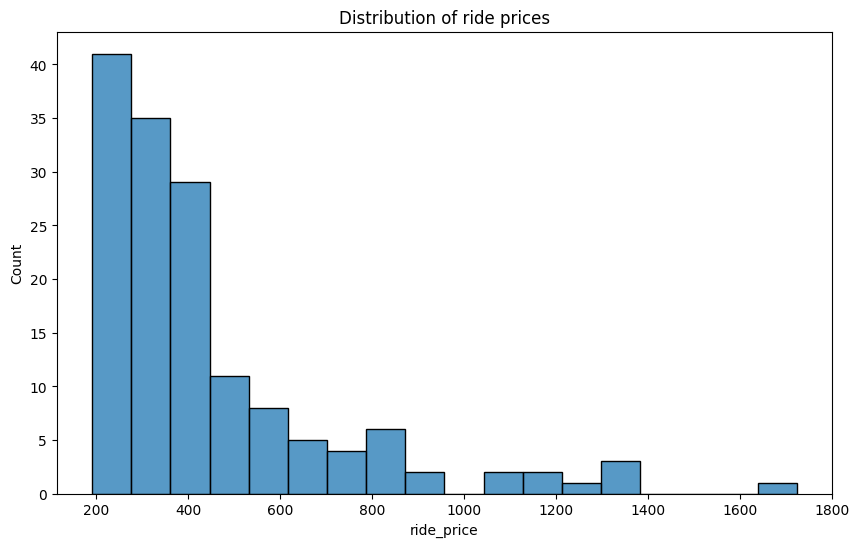

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data["ride_price"])
plt.title("Distribution of ride prices")
plt.show()

Remove outlier

In [14]:
Q1 = data["ride_price"].quantile(0.25)
Q3 = data["ride_price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data["ride_price"] >= lower_bound) & (data["ride_price"] <= upper_bound)]

In [15]:
data.shape

(128, 7)

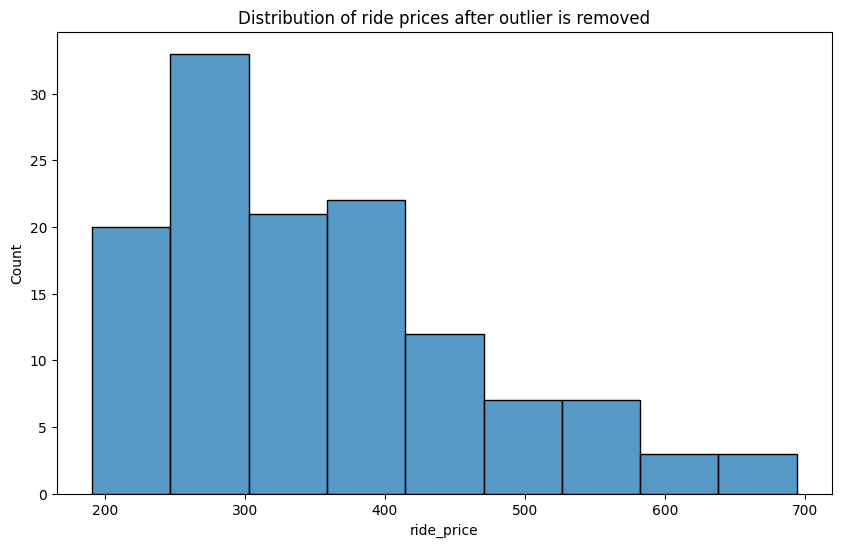

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data["ride_price"])
plt.title("Distribution of ride prices after outlier is removed")
plt.show()

Regression

In [37]:
x = data.drop("ride_price", axis=1)
y = data["ride_price"]

numeric_features = x.select_dtypes(include="number").columns
categorical_features = x.select_dtypes(include="object").columns

In [38]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0
)

In [39]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [40]:
model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("regressor", LinearRegression()),
    ]
)


model.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['Distance(km)', 'Duration(min)', 'fuel_price(per liter)',
       'Traffic_level_Gridlock', 'Traffic_level_Heavy',
       'Traffic_level_Moderate', 'Traffic_level_Normal',
       'vehicle_type_Economy', 'vehicle_type_Luxury', 'Demand_level_Low',
       'Demand_level_Medium'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('regressor', LinearRegression())])

In [41]:
y_pred = model.predict(x_test)